In [1]:
import mne
import pickle
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load the data 

In [2]:
# dataset contains a list of mne EpochsArray (datastructure)
# epoch duration : 600ms
# sampling rate: 128hz
# nb of time points per epoch: 76 (equates to ~600ms)
filename = "C:/Users/Manu/Documents/PolyAi/poly_cortex/data/data/data_allsubjects"
with open(filename, 'rb') as handle:
    data= pickle.load(handle)


['FCz', 'C3', 'C1', 'Cz', 'C2', 'C4', 'CPz', 'P7', 'P3', 'P4', 'P8', 'PO3', 'POz', 'PO4', 'O1', 'O2']


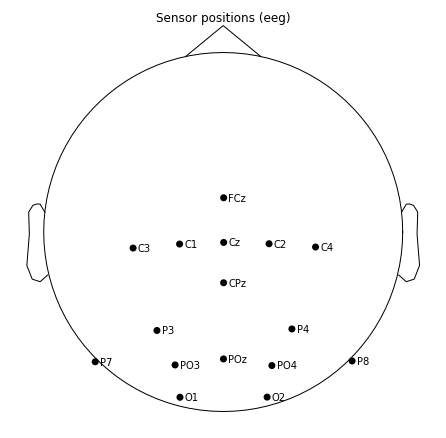

2
4
6
(10528, 16, 76)
(10528,)
(1623, 16, 76)
(8905, 16, 76)


In [3]:
# construct X,Y dataset for binary classification:
duration = 0.6
nb_time_point = 76
# ['FCz', 'C3', 'C1', 'Cz', 'C2', 'C4', 'CPz', 'P7', 'P3', 'P4', 'P8', 'PO3', 'POz', 'PO4', 'O1', 'O2']

SELECTED_CHANNELS = ['FCz', 'Cz', 'CPz', 'P7', 'P3', 'P4', 'P8', 'PO3', 'POz', 'PO4', 'O1', 'O2']
GOOD_SUBJECTS = [1, 2, 4, 6]


X, Y = [], []  
first_subject = True
for i,subject in enumerate(data):
    if i not in GOOD_SUBJECTS:
        continue
    
    # filtering channels
    #subject = subject.pick(SELECTED_CHANNELS)
    if first_subject:
        channels = subject.ch_names
        print(channels)
        subject.plot_sensors(show_names=True)
        
        target = subject['pos'].get_data()
        nonTarget = subject['neg'].get_data()   
                  
        X = np.concatenate([target, nonTarget])
        Y = np.concatenate([np.ones(target.shape[0]), np.zeros(nonTarget.shape[0])])
        first_subject = False

        
    else:
        target_subj = subject['pos'].get_data()
        nonTarget_subj = subject['neg'].get_data()   
        X_subj, Y_subj = [], []            
        X_subj = np.concatenate([target_subj, nonTarget_subj])        
        Y_subj = np.concatenate([np.ones(target_subj.shape[0]), np.zeros(nonTarget_subj.shape[0])])
        X = np.concatenate([X,X_subj])
        Y = np.concatenate([Y,Y_subj])
        target = np.concatenate([target,target_subj])
        nonTarget = np.concatenate([nonTarget,nonTarget_subj])
        print(i)
    

print(X.shape)
print(Y.shape)
print(target.shape)
print(nonTarget.shape)
       

Nous avons maintenant un array avec les signaux eeg pour les 16 patients combinés, avec le ground truth (target or non target) correspondant qui est enregistré dans le array Y. Pour le premier des 16 sujets, on a donc 3982 lettres qui ont flashés (ce qu'on appelle trial), et 569 fois cela correspondait à la lettre qu'il regardait (ce qu'on appelle target). Pour chacun des 3982 trials, on a accès au signal eeg (composé de 76 time point) provenant de chacune des 16 électrodes (channel). On peut considérer le preprocessing déjà réalisé. En effet selon l'article:  

The following pre-processing steps have been done:

1) Detrending 
2) Remove bad channels
3) Common-Average Referencing 
4) Remove bad epochs
5) Band pass filtering in the range of [0. 15];  


    Using multitaper spectrum estimation with 7 DPSS windows


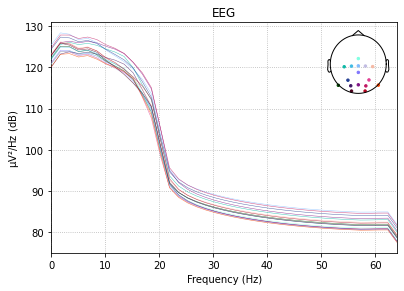

In [4]:
%matplotlib inline
data[0].plot_psd();

#### Le power spectrum est vraiment bien, on voit bien que les donnees ont ete filtrees entre 0 et 15 Hz.  
  
#### Regardons maintenant de quoi ont l'air les signaux eeg à travers les différentes époques de 600 ms. Un pic positif devrait apparait à environ 300 ms pour les époques "target". La ligne verte représente le signal moyen.

x = np.linspace(0, duration, nb_time_point)
fig, axes = plt.subplots(figsize = (200,12),ncols=16,nrows=2)
axes = axes.flat
for i in range(0,len(channels)):
    axes[i].set_title(channels[i])
    axes[i].set_ylabel("Amplitude target (uV)")
    axes[i].set_xlabel("Time (s)")
    axes[i+16].set_ylabel("Amplitude non target (uV)")
    axes[i+16].set_xlabel("Time (s)")
    

    mean_target = np.mean(target, axis=0)
    mean_non_target = np.mean(nonTarget,axis=0)

    axes[i].plot(x,mean_target[i], label='mean target',color='g')
    axes[i+16].plot(x,mean_non_target[i], label='mean non target',color='g')

    for channel in target[i]:
        axes[i].plot(x, channel, label="target", color='orange',alpha=0.1)

    for channel in nonTarget[i]:
        axes[i+16].plot(x, channel, label="non target", color='blue',alpha=0.1)


#### Visualisons maintenant seulement les moyennes des signaux (pour avoir une meilleure échelle).

fig, axes = plt.subplots(figsize = (200,6),ncols=16, nrows=1)
axes = axes.flat
for i in range(0,len(channels)):
    axes[i].set_title(channels[i])
    axes[i].set_ylabel("Amplitude target (uV)")
    axes[i].set_xlabel("Time (s)")
    
    mean_target = np.mean(target, axis=0)
    mean_non_target = np.mean(nonTarget,axis=0)

    axes[i].plot(x,mean_target[i], label='mean target',color='g')
    axes[i].plot(x,mean_non_target[i], label='mean non target',color='r')
    axes[i].legend()

#### On remarque que les channels FCz, C3, C1, C4(potentiel négatif est peut-être causé par inversion par rapport à la référence), P7, P3, P4, P8 et PO3 ont tous une variation positive vers 300 ms, qui se distingue nettement du non-target. Ce pourrait donc être des électrodes de choix pour notre projet.

À faire:  
$-[ ]$ Separer donnees d'entrainement et de test  
$-[ ]$ Comparer avec la littérature pour savoir quel channel seront les meilleurs (et garder en tête que nous devrons utilisé les mêmes pour notre jeu)  
$-[ ]$ Trouver comment extraire des features  

## Feature extraction

In [5]:
from sklearn.pipeline import Pipeline

from mne.decoding import Vectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

COMPRESSION_FACTOR = 4

print(f'X shape: {X.shape}')
X_zip = np.ndarray(shape=(X.shape[0], X.shape[1], X.shape[2]//COMPRESSION_FACTOR))
for i, epoch in enumerate(X):
    test = [np.mean(x, axis=1) for x in np.split(epoch, 76/COMPRESSION_FACTOR, axis=1)]
    X_zip[i] = np.array(test).T


print(f'Compressed X shape: {X_zip.shape}')
X = X_zip

scaler = StandardScaler()
X = scaler.fit_transform(X.reshape((X.shape[0], X.shape[1]*X.shape[2])))
print(f'Flattenned : {X.shape}')

X shape: (10528, 16, 76)
Compressed X shape: (10528, 16, 19)
Flattenned : (10528, 304)


#### On commence par un simple LR, juste pour se mettre dedans et tester si la structure des données est valide pour fitter les différents algo de ML. 

(8422, 304)
(2106, 304)
All channels
              precision    recall  f1-score   support

         0.0       0.94      0.78      0.85      1781
         1.0       0.38      0.74      0.50       325

    accuracy                           0.77      2106
   macro avg       0.66      0.76      0.68      2106
weighted avg       0.85      0.77      0.80      2106



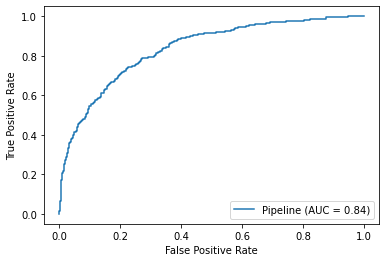

In [6]:
# split data in train and test set
#subjects:  {0: 65%, 1: 85%, 2: 85%+, 3: 75%, 4: 85%+, 5: 80, 6:90, 7:79, 8:75, 9:75, 10:80, 11: 70, 12: 80+}


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=Y, test_size=0.2)
from sklearn.metrics import plot_roc_curve
print(X_train.shape)
print(X_test.shape)

pipeline_LR = Pipeline([('logistic_Regression', LogisticRegression(n_jobs=-1, class_weight='balanced')) ])

# for i, channel in enumerate(channels):
#     pipeline_LR.fit(X_train[:,i,:],Y_train)

#     pred= pipeline_LR.predict(X_test[:,i,:])
#     print(channel)
#     print(classification_report(Y_test,pred),'\n\n')

#all channels together

pipeline_LR = Pipeline([('logistic_Regression', LogisticRegression(n_jobs=-1, class_weight='balanced')) ])
pipeline_LR.fit(X_train,Y_train)
pred= pipeline_LR.predict(X_test)
print("All channels")
print(classification_report(Y_test,pred))

plot_roc_curve(pipeline_LR, X_test, Y_test)

plt.show()

              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92      1781
         1.0       0.86      0.04      0.07       325

    accuracy                           0.85      2106
   macro avg       0.85      0.52      0.49      2106
weighted avg       0.85      0.85      0.79      2106



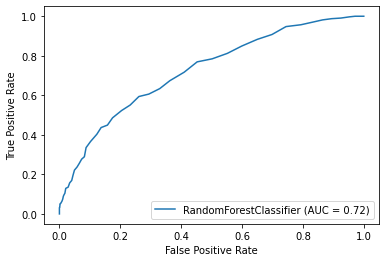

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_roc_curve

rf_clf = RandomForestClassifier(n_jobs=-1)
rf_clf.fit(X_train, Y_train)
pred = rf_clf.predict(X_test)

print(classification_report(Y_test,pred))
plot_roc_curve(rf_clf, X_test, Y_test)

plt.show()

              precision    recall  f1-score   support

         0.0       0.89      0.97      0.93      1781
         1.0       0.65      0.34      0.45       325

    accuracy                           0.87      2106
   macro avg       0.77      0.66      0.69      2106
weighted avg       0.85      0.87      0.85      2106



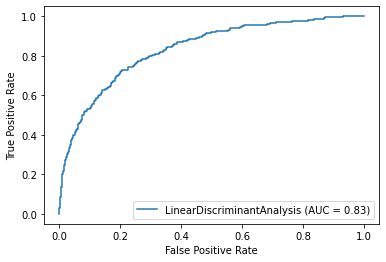

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train, Y_train)
pred = lda_clf.predict(X_test)

print(classification_report(Y_test,pred))

plot_roc_curve(lda_clf, X_test, Y_test)

plt.show()


              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92      1781
         1.0       0.71      0.02      0.03       325

    accuracy                           0.85      2106
   macro avg       0.78      0.51      0.47      2106
weighted avg       0.83      0.85      0.78      2106



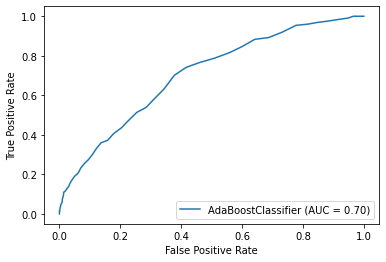

In [9]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(base_estimator=rf_clf)
clf.fit(X_train, Y_train)
pred = clf.predict(X_test)

print(classification_report(Y_test,pred))

plot_roc_curve(clf, X_test, Y_test)

plt.show()

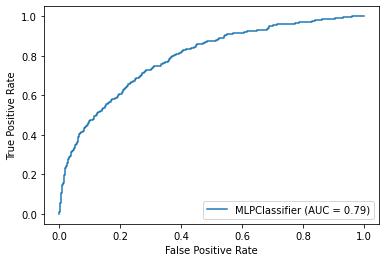

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import plot_roc_curve

nn_clf = MLPClassifier()
nn_clf.fit(X_train, Y_train)
pred = nn_clf.predict(X_test)
plot_roc_curve(nn_clf, X_test, Y_test)

plt.show()

#### Regardons si le SVM donne de meilleurs résultats

In [11]:
pipeline_SVM = Pipeline([('svm', SVC(class_weight='balanced')) ])

for i, channel in enumerate(channels):
    pipeline_SVM.fit(X_train[:,i,:],Y_train)

    pred= pipeline_SVM.predict(X_test[:,i,:])
    print(channel)
    print(classification_report(Y_test,pred),'\n\n')


pipeline_SVM = Pipeline([('vectorizer', Vectorizer()), ('std_scaler', StandardScaler()),('svm', SVC(class_weight='balanced')) ])
pipeline_SVM.fit(X_train,Y_train)
pred= pipeline_SVM.predict(X_test)
print("All channels")
print(classification_report(Y_test,pred))

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed